Import libraries:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re

Load dataset:

In [2]:
fake_df = pd.read_csv("datasets/Fake.csv")
real_df = pd.read_csv("datasets/True.csv")

Add labels to both datasets:

In [3]:
fake_df['label'] = 0
real_df['label'] = 1

Join both datasets:

In [4]:
df = pd.concat([fake_df,real_df],axis = 0).reset_index(drop = True)

Shuffle dataset:

In [5]:
df = df.sample(frac = 1).reset_index(drop=True)

ChecK null values:

In [6]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

Check duplicated:

In [7]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
44893    False
44894    False
44895    False
44896    False
44897     True
Length: 44898, dtype: bool

Text Cleaning of dataset:

In [8]:
def textCleaning(text):
    text = text.lower()
    text =  re.sub(r'\S*[\\/]\S*', "", text)
    text = re.sub(r"[^a-z\s]","",text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['Clean Title'] = df['title'].apply(textCleaning)
df['Clean Text'] = df['text'].apply(textCleaning)

    

In [9]:
df['News'] = df['Clean Title'] + " " + df['Clean Text']

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
def wordTokenization(text):
    token = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokenize_text = [word for word in token if word not in stop_words]
    return tokenize_text
df['Tokenize Text'] = df['News'].apply(wordTokenization)

Mapping of subject:

In [11]:
df['subject'] = df['subject'].map({
    'News':0,
    'politicsNews':1,
    'US_News':2,
    'left-news':3,
    'worldnews':4,
    'politics':5,
    'Middle-east':6,
    'Government News':7
})

convert date into suitable format:

In [12]:
df['date'] = pd.to_datetime(df['date'].str.strip(), format='mixed', errors='coerce')

Vectorizer:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
df['Tokenize Text Str'] = df['Tokenize Text'].apply(lambda x: " ".join(x))
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2), sublinear_tf=True)
tfid_matrix = vectorizer.fit_transform(df["Tokenize Text Str"])


Model:

In [14]:
from sklearn.svm import LinearSVC
model = LinearSVC(C=5, class_weight='balanced', max_iter=5000)


Spliting:

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(tfid_matrix,df['label'],test_size=0.3,random_state=42)

Training:

In [16]:
model.fit(x_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,5
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model.predict(x_test)
print("Accuraccy:",accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
print("Confusion matrix:\n",cm)
print("Classification report:\n",classification_report(y_test,y_pred))

Accuraccy: 0.9978470675575353
Confusion matrix:
 [[6959   24]
 [   5 6482]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6983
           1       1.00      1.00      1.00      6487

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



Heatmap:

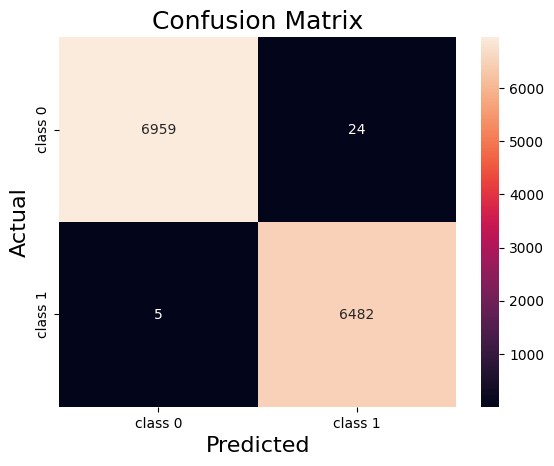

In [18]:
sns.heatmap(cm,annot=True,fmt='d', xticklabels=['class 0','class 1'],yticklabels=['class 0','class 1'])
plt.title("Confusion Matrix", fontsize = 18)
plt.xlabel("Predicted", fontsize = 16)
plt.ylabel("Actual", fontsize = 16)
plt.show()

In [19]:
sample = input("Enter news:")
sample_clean = textCleaning(sample)
sample_tokens = wordTokenization(sample_clean)
sample_matrix =  vectorizer.transform([" ".join(sample_tokens)])
prediction = model.predict(sample_matrix)
print(prediction)

[0]


In [20]:
import joblib
joblib.dump(model, "model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']